# Density Estimation

In [1]:
%load_ext jupyter_black

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_biclusters
from sklearn.neighbors import NearestNeighbors, KernelDensity

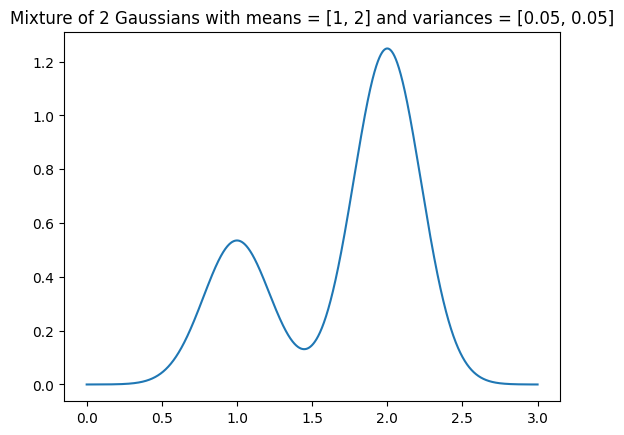

In [3]:
means = [1, 2]
variances = [0.05, 0.05]
proportions = [0.3, 0.7]
x = np.linspace(0, 3, 3000)
y = proportions[0] * sp.stats.norm.pdf(
    x, loc=means[0], scale=np.sqrt(variances[0])
) + proportions[1] * sp.stats.norm.pdf(x, loc=means[1], scale=np.sqrt(variances[1]))
plt.title(
    "Mixture of 2 Gaussians with means = "
    + str(means)
    + " and variances = "
    + str(variances)
)
plt.plot(x, y)

In [4]:
# 1d data
np.random.seed(123)
N = 150
n1 = int(N * proportions[0])
n2 = N - n1
sampled_points = np.random.normal(means[0], np.sqrt(variances[0]), n1)
sampled_points = np.append(
    sampled_points, np.random.normal(means[1], np.sqrt(variances[1]), n2)
)

# 2d data
N2d = 100
np.random.seed(42)
class1 = np.random.multivariate_normal(
    mean=[0, 0], cov=[[1.0, 0.1], [0.1, 5]], size=N2d
)
class2 = np.random.multivariate_normal(mean=[0, 0], cov=[[5, 0.1], [0.1, 1]], size=N2d)

train_data = np.vstack([class1, class2])
train_labels = np.array([0] * N2d + [1] * N2d)

grids_x, grids_y = np.meshgrid(
    np.linspace(train_data.min(axis=0)[0], train_data.max(axis=0)[0], 100),
    np.linspace(train_data.min(axis=0)[1], train_data.max(axis=0)[1], 100),
)
grid_points = np.c_[grids_x.ravel(), grids_y.ravel()]

# Histogramms

/tmp/ipykernel_40019/264915361.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


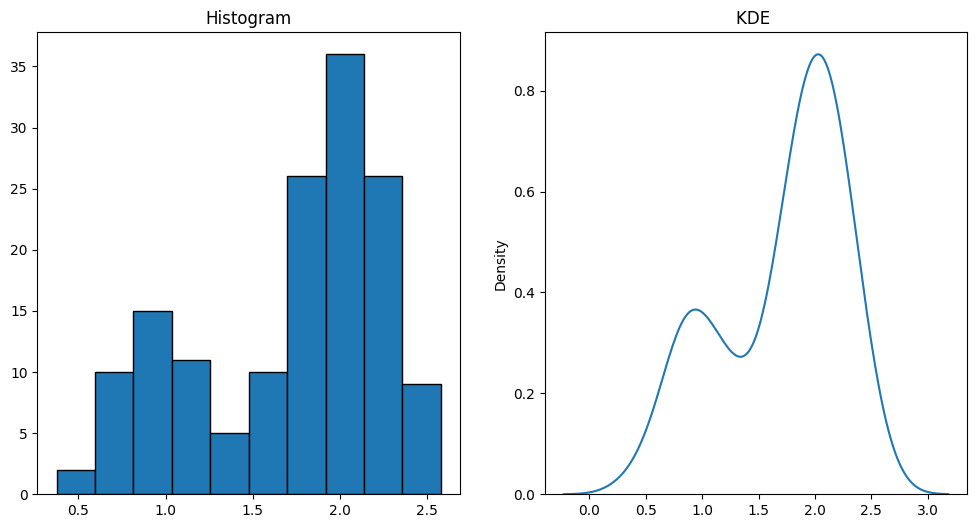

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.set_title("Histogram")
ax1.hist(sampled_points, bins=10, edgecolor="k")

ax2.set_title("KDE ")
sns.kdeplot(sampled_points, ax=ax2)

fig.show()

BTW, how to solce classification tasks given the density estimates?

/tmp/ipykernel_40019/6197113.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


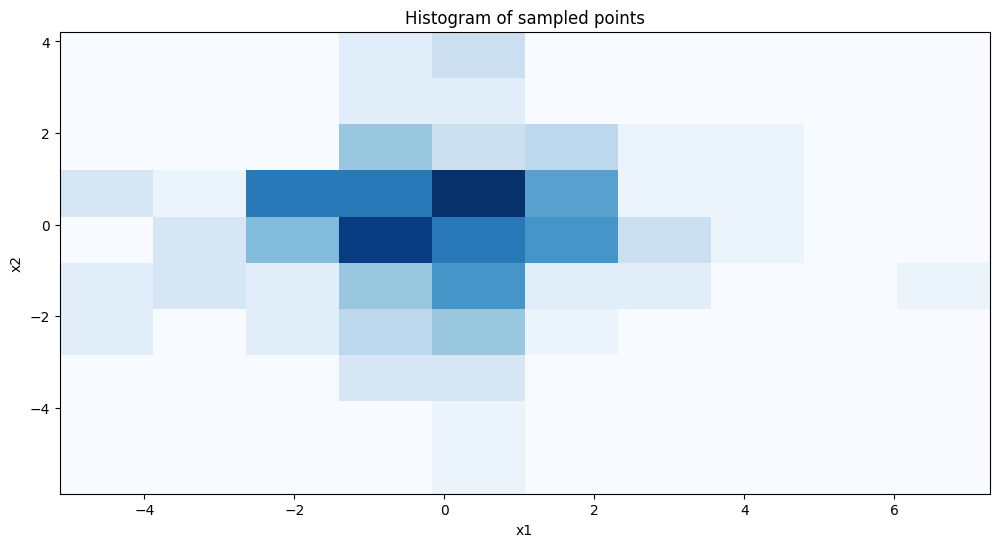

In [6]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))

ax1.set_title("2d Histogram")
# Histogram of sampled points
ax1.set_title("Histogram of sampled points")
ax1.hist2d(train_data[:, 0], train_data[:, 1], bins=10, cmap="Blues")
ax1.set_xlabel("x1")
ax1.set_ylabel("x2")

ax2.set_title("KDE of " + str(N) + " points sampled from a mixture of 2 Gaussians")
sns.kdeplot(sampled_points, ax=ax2)

fig.show()

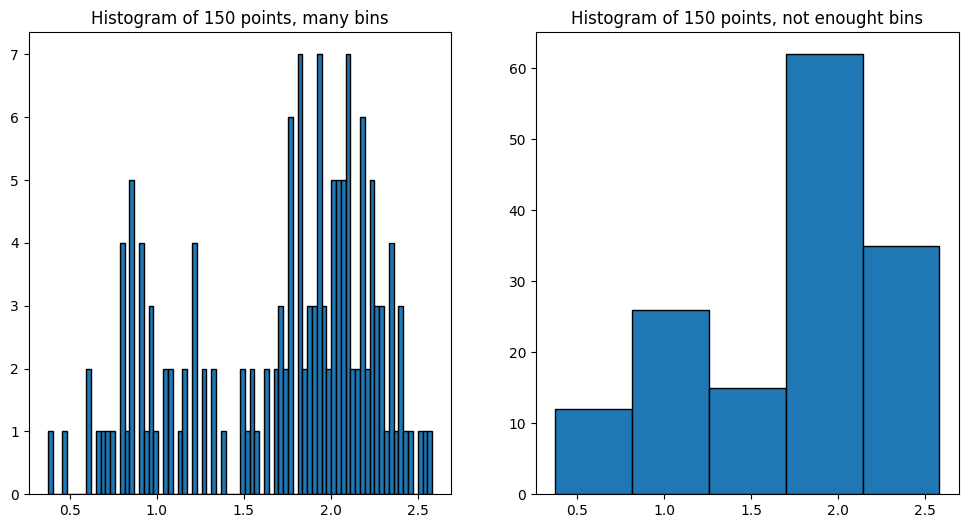

In [7]:
# it depends heavily on the number of points
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.set_title(f"Histogram of {N} points, many bins")
ax1.hist(sampled_points, bins=80, edgecolor="k")

ax2.set_title(f"Histogram of {N} points, not enought bins")
ax2.hist(sampled_points, bins=5, edgecolor="k");

# Version 1: fix K, vary V

In other case, we estimate each point density as 1 / (radius of the sphere which contains k neighbours)


**TODO:** why it diverges?

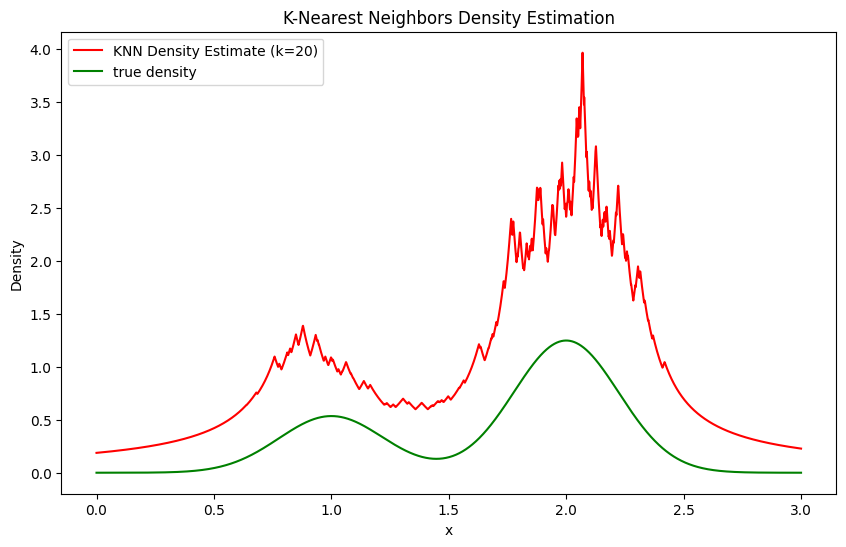

In [8]:
k = 20
eps = 0.00001

nbrs = NearestNeighbors(n_neighbors=k).fit(sampled_points.reshape(-1, 1))
distances, indices = nbrs.kneighbors(x.reshape(-1, 1), n_neighbors=k)
radii = distances[:, -1]
density = 1 / (radii + eps)


plt.figure(figsize=(10, 6))
plt.plot(
    x, density / density.mean(), label=f"KNN Density Estimate (k={k})", color="red"
)
plt.plot(x, y, color="green", label="true density")

plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.title("K-Nearest Neighbors Density Estimation")
plt.show()

/tmp/ipykernel_40019/860705229.py:63: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


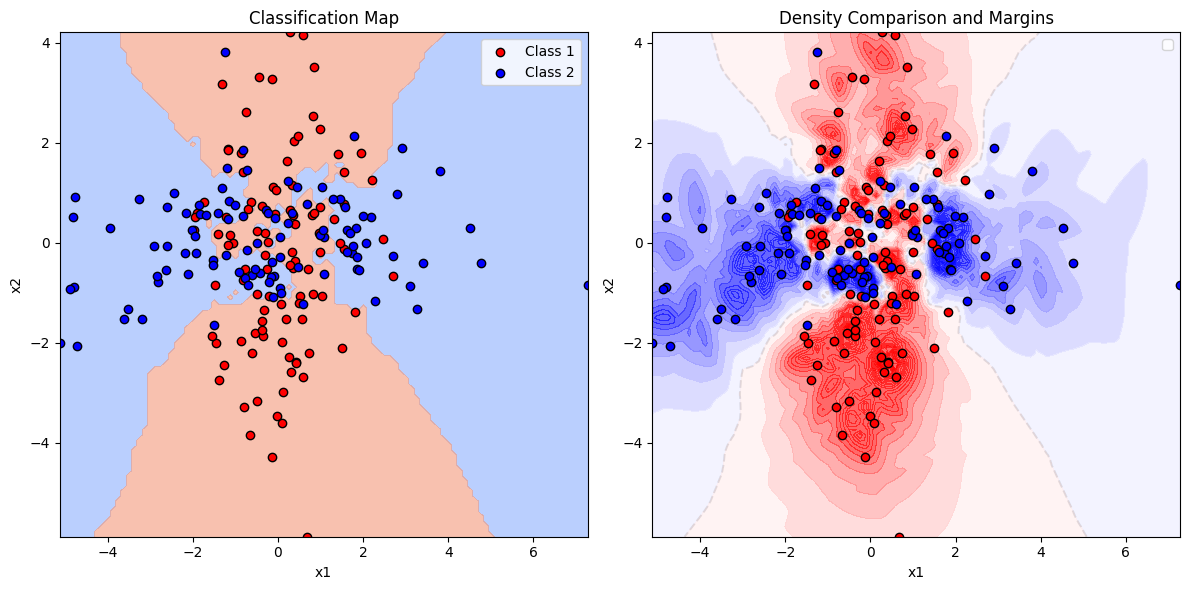

In [9]:
k = 4

nbrs_class1 = NearestNeighbors(n_neighbors=k).fit(class1)
nbrs_class2 = NearestNeighbors(n_neighbors=k).fit(class2)
distances_class1, _ = nbrs_class1.kneighbors(grid_points, n_neighbors=k)
distances_class2, _ = nbrs_class2.kneighbors(grid_points, n_neighbors=k)
radii_class1 = distances_class1[:, -1]
radii_class2 = distances_class2[:, -1]
density_class1 = 1 / radii_class1
density_class2 = 1 / radii_class2
density_class1 = density_class1.reshape(grids_x.shape)
density_class2 = density_class2.reshape(grids_x.shape)


# classification map
classification_map = (
    (density_class1 > density_class2).astype(int).reshape(grids_x.shape)
)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.contourf(
    grids_x,
    grids_y,
    classification_map,
    levels=[-0.5, 0.5, 1.5],
    alpha=0.6,
    cmap="coolwarm",
)
plt.scatter(class1[:, 0], class1[:, 1], c="red", label="Class 1", edgecolor="k")
plt.scatter(class2[:, 0], class2[:, 1], c="blue", label="Class 2", edgecolor="k")
plt.title("Classification Map")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()

plt.subplot(1, 2, 2)
plt.contourf(
    grids_x,
    grids_y,
    density_class1 - density_class2,
    levels=100,
    alpha=0.6,
    cmap="bwr",
    vmin=-1,
    vmax=1,
)
plt.contour(
    grids_x,
    grids_y,
    density_class1 - density_class2,
    levels=[0],
    colors="black",
    alpha=0.1,
    linestyles="dashed",
)

plt.scatter(class1[:, 0], class1[:, 1], c="red", edgecolor="k")
plt.scatter(class2[:, 0], class2[:, 1], c="blue", edgecolor="k")
plt.title("Density Comparison and Margins")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()

plt.tight_layout()
plt.show()

# Version 2: Fix V, vary K

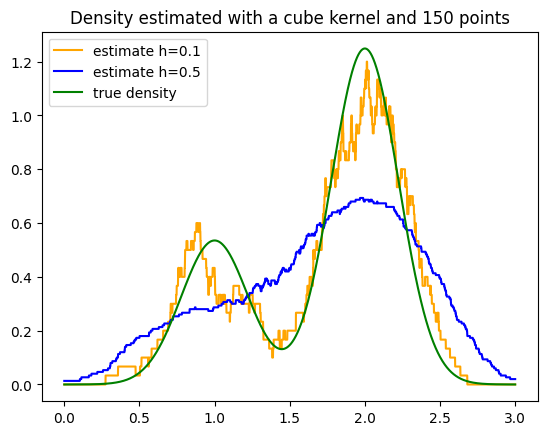

In [10]:
def parcel_density1d(data, grid, radius, shape="sphere"):
    ...

plt.title(
    "Density estimated with a cube kernel and " + str(len(sampled_points)) + " points"
)
plt.plot(
    x,
    parcel_density1d(sampled_points, x, radius=0.1, shape="sphere"),
    color="orange",
    label="estimate h=0.1",
)

plt.plot(
    x,
    parcel_density1d(sampled_points, x, radius=0.5, shape="sphere"),
    color="blue",
    label="estimate h=0.5",
)


plt.plot(x, y, color="green", label="true density")

plt.legend()

/tmp/ipykernel_40019/3707194271.py:2: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  class1 = np.random.multivariate_normal(
/tmp/ipykernel_40019/3707194271.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  class2 = np.random.multivariate_normal(mean=[0, 0], cov=[[5, -0.1], [0.1, 1]], size=100)
/tmp/ipykernel_40019/3707194271.py:44: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(


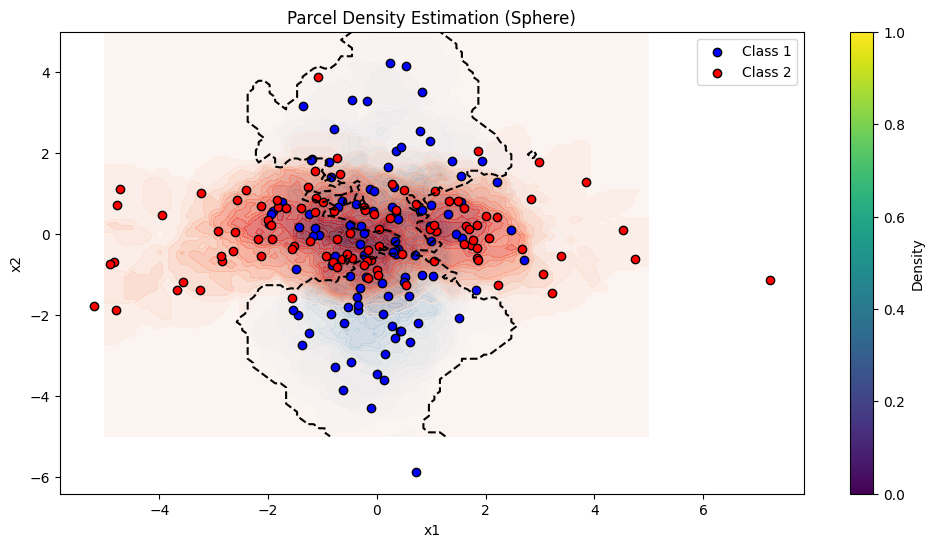

/tmp/ipykernel_40019/3707194271.py:84: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(


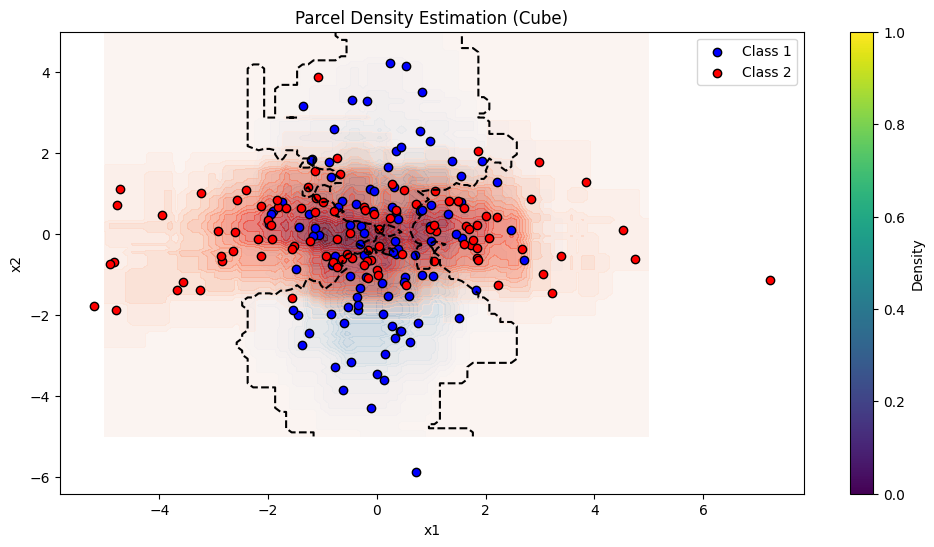

In [11]:
def parcel_density(data, grid, radius, shape="sphere"):
   ...


density_class1_parcel = parcel_density(class1, grid_points, radius, shape="sphere")
density_class2_parcel = parcel_density(class2, grid_points, radius, shape="sphere")
density_class1_parcel = density_class1_parcel.reshape(grids_x.shape)
density_class2_parcel = density_class2_parcel.reshape(grids_x.shape)
plt.figure(figsize=(12, 6))

plt.contourf(
    grids_x, grids_y, density_class1_parcel, levels=20, alpha=0.6, cmap="Blues"
)
plt.contourf(grids_x, grids_y, density_class2_parcel, levels=20, alpha=0.6, cmap="Reds")

plt.contour(
    grids_x,
    grids_y,
    density_class1_parcel - density_class2_parcel,
    levels=[0],
    colors="black",
    linestyles="dashed",
    label="Equal-Density Margin (Parcel)",
)

plt.scatter(class1[:, 0], class1[:, 1], c="blue", label="Class 1", edgecolor="k")
plt.scatter(class2[:, 0], class2[:, 1], c="red", label="Class 2", edgecolor="k")

plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.title("Parcel Density Estimation (Sphere)")
plt.colorbar(label="Density")
plt.show()

parcel_shape = "cube"
density_class1_parcel_cube = parcel_density(
    class1, grid_points, radius, shape=parcel_shape
)
density_class2_parcel_cube = parcel_density(
    class2, grid_points, radius, shape=parcel_shape
)

density_class1_parcel_cube = density_class1_parcel_cube.reshape(grids_x.shape)
density_class2_parcel_cube = density_class2_parcel_cube.reshape(grids_x.shape)

plt.figure(figsize=(12, 6))

plt.contourf(
    grids_x, grids_y, density_class1_parcel_cube, levels=20, alpha=0.6, cmap="Blues"
)
plt.contourf(
    grids_x, grids_y, density_class2_parcel_cube, levels=20, alpha=0.6, cmap="Reds"
)

plt.contour(
    grids_x,
    grids_y,
    density_class1_parcel_cube - density_class2_parcel_cube,
    levels=[0],
    colors="black",
    linestyles="dashed",
    label="Equal-Density Margin (Cube)",
)
plt.scatter(class1[:, 0], class1[:, 1], c="blue", label="Class 1", edgecolor="k")
plt.scatter(class2[:, 0], class2[:, 1], c="red", label="Class 2", edgecolor="k")

plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.title("Parcel Density Estimation (Cube)")
plt.colorbar(label="Density")
plt.show()

# Kernels

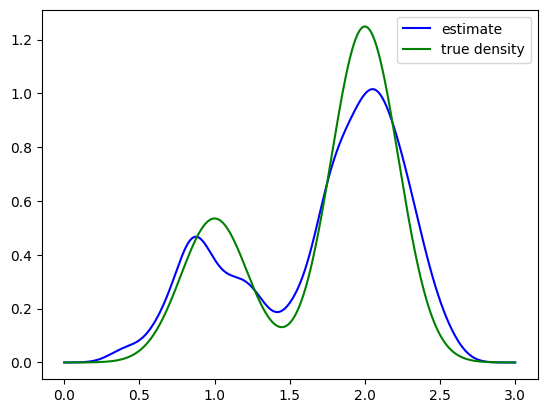

In [12]:
def kernel_density1d(data, grid, scale):
    ...


plt.plot(
    x,
    kernel_density1d(sampled_points, x, scale=0.1),
    color="blue",
    label="estimate",
)
plt.plot(x, y, color="green", label="true density")

plt.legend()

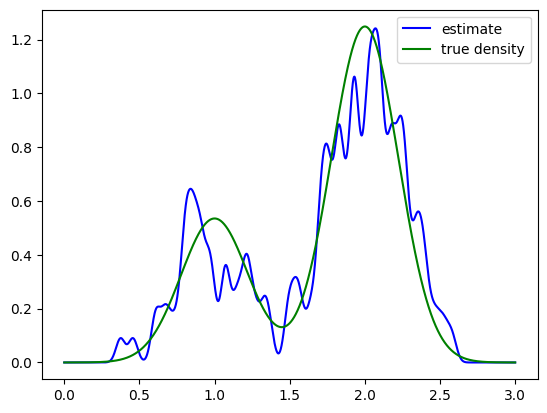

In [14]:
plt.plot(
    x,
    kernel_density1d(sampled_points, x, scale=0.03),
    color="blue",
    label="estimate",
)
plt.plot(x, y, color="green", label="true density")

plt.legend()

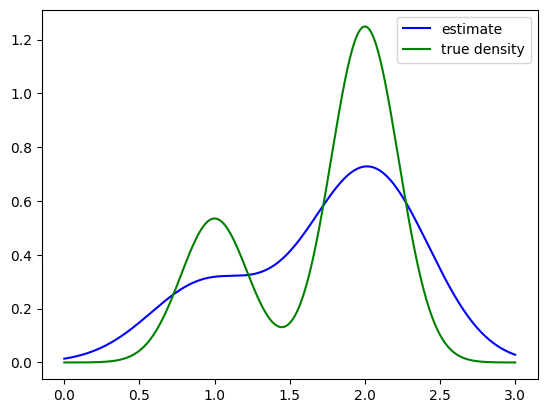

In [15]:
plt.plot(
    x,
    kernel_density1d(sampled_points, x, scale=0.3),
    color="blue",
    label="estimate",
)
plt.plot(x, y, color="green", label="true density")

plt.legend()

/tmp/ipykernel_40019/1065610060.py:20: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(


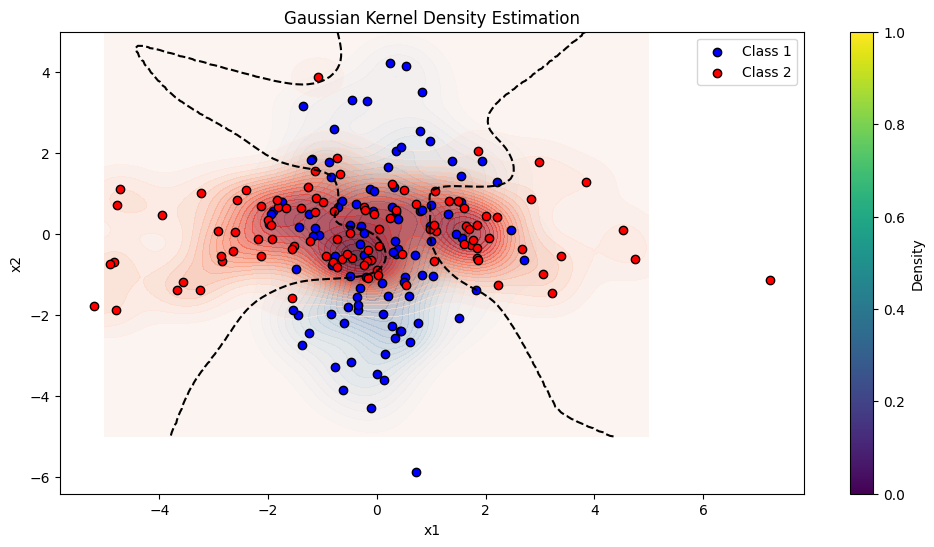

In [16]:
bandwidth = 0.5

kde_class1 = KernelDensity(bandwidth=bandwidth, kernel="gaussian")
kde_class1.fit(class1)
kde_class2 = KernelDensity(bandwidth=bandwidth, kernel="gaussian")
kde_class2.fit(class2)

log_density_class1 = kde_class1.score_samples(grid_points)
log_density_class2 = kde_class2.score_samples(grid_points)
density_class1_kde = np.exp(log_density_class1)
density_class2_kde = np.exp(log_density_class2)

density_class1_kde = density_class1_kde.reshape(grids_x.shape)
density_class2_kde = density_class2_kde.reshape(grids_x.shape)
plt.figure(figsize=(12, 6))

plt.contourf(grids_x, grids_y, density_class1_kde, levels=20, alpha=0.6, cmap="Blues")
plt.contourf(grids_x, grids_y, density_class2_kde, levels=20, alpha=0.6, cmap="Reds")

plt.contour(
    grids_x,
    grids_y,
    density_class1_kde - density_class2_kde,
    levels=[0],
    colors="black",
    linestyles="dashed",
    label="Equal-Density Margin (KDE)",
)

plt.scatter(class1[:, 0], class1[:, 1], c="blue", label="Class 1", edgecolor="k")
plt.scatter(class2[:, 0], class2[:, 1], c="red", label="Class 2", edgecolor="k")

plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.title("Gaussian Kernel Density Estimation")
plt.colorbar(label="Density")

---

This notebook is heavily based on Cristoffer Bishop's book Pattern Recognition and Machie Learning, Chapter 2. 